-------------------------------------
# ECG Beat classification:
### Model - CNN

### Data Method - Patient leave-out

-------------------------------------

### Imports

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import seaborn as sns
from sklearn import *
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, LeakyReLU
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Activation
import itertools
import time
from sklearn.utils import resample
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import ECG.eager_ops
from ECG import eager_ops
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.model_selection import train_test_split


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
print("You are using Tensorflow version", tf.__version__)

print(tf.config.list_physical_devices('GPU'))

You are using Tensorflow version 2.1.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# path = './drive/MyDrive/Colab_Notebooks/ECG_with_Expected_gradients/'
path = './'

In [4]:
os.listdir(path)

['CNN_holdout_patients_EG_train_test.ipynb',
 'Data',
 'ECG',
 'eval_data_10k',
 'LSTM_leaveout_patients_EG_train_test.ipynb',
 'RAN_MODELS']

### Loading data

In [5]:
train_c1 = np.genfromtxt(path+'Data/train_beats_sc.csv', delimiter=',')
train_c0 = np.genfromtxt(path+'Data/train_beats_fc.csv', delimiter=',')
test_c1 = np.genfromtxt(path+'Data/test_beats_sc.csv', delimiter=',')
test_c0 = np.genfromtxt(path+'Data/test_beats_fc.csv', delimiter=',')

train_x_c01 = np.concatenate((train_c0[:, :-2], train_c1[:, :-2]), axis=1)
train_y_c01 = np.concatenate((train_c0[:, -2:], train_c1[:, -2:]), axis=1)

test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
test_y_c01 = np.concatenate((test_c0[:, -2:], test_c0[:, -2:]), axis=1)

train_x = train_x_c01.reshape(-1, train_x_c01.shape[1], 1).astype('float32')
test_x = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')

train_y = tf.keras.utils.to_categorical(train_y_c01[:,0])
test_y = tf.keras.utils.to_categorical(test_y_c01[:,0])

print("Train:")
print("x:", train_x.shape, "y:", train_y.shape)
print("Test")
print("x:", test_x.shape, "y:", test_y.shape)

Train:
x: (28984, 920, 1) y: (28984, 9)
Test
x: (27219, 920, 1) y: (27219, 9)


### Creating a performance metrics function

In [6]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score_macro = f1_score(test, pred, average='macro') 
    f1score_micro = f1_score(test, pred, average='micro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score macro : {}".format(f1score_macro))
    print("f1score micro : {}".format(f1score_micro))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score_macro,3), 
            round(f1score_micro, 3), cm)

### Function for building the CNN model

In [7]:
opt = Adam(learning_rate=0.001)

def getCNNModel():
    
    input = keras.layers.Input(shape=(train_x.shape[1],train_x.shape[2]))
    x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)

    #block 2

    x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    x = keras.layers.Dropout(0.2)(x)

    #block 3
    for i in range(4):


        shortcut = MaxPooling1D(pool_size=1)(x)

        filters = 64 * ((i//2)+1)
        # print("Filter size = "+str(filters))
        x = keras.layers.Conv1D(kernel_size=16, filters=filters, strides=1, use_bias=True, padding="same", kernel_initializer='VarianceScaling')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU(alpha=0.3)(x)

        x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, padding="same", kernel_initializer='VarianceScaling')(x)

        x = keras.layers.LeakyReLU(alpha=0.3)(x)
        x = keras.layers.Dropout(0.2)(x)
    

        x = tf.keras.layers.Add()([x, shortcut])


    x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    x = keras.layers.Flatten()(x)
    out = keras.layers.Dense(9, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=[input], outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

### List of models

In [8]:
cnn1 = getCNNModel()
cnn2 = getCNNModel()
cnn3 = getCNNModel()
cnn4 = getCNNModel()
cnn5 = getCNNModel()
cnn6 = getCNNModel()
cnn7 = getCNNModel()
cnn8 = getCNNModel()
cnn9 = getCNNModel()
cnn10 = getCNNModel()

modellist = [cnn1, cnn2, cnn3, cnn4, cnn5, cnn6, cnn7, cnn8, cnn9, cnn10]

### Defining training functions and parameters

In [9]:
lamb = 0.0001
num_epochs = 10
batch_size = 50
optimizer = tf.optimizers.Adam(learning_rate = 0.0001)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
val_loss_fn = tf.keras.losses.CategoricalCrossentropy()
train_acc_fn = tf.keras.metrics.CategoricalAccuracy()
val_acc_fn = tf.keras.metrics.CategoricalAccuracy()
test_acc_fn = tf.keras.metrics.CategoricalAccuracy()

In [10]:
#train step
def train_step(model_m, inputs, labels):
    with tf.GradientTape() as tape:
        tape.watch(tf.convert_to_tensor(inputs))
        predictions = model_m(inputs, training=True)
        pred_loss = loss_fn(labels, predictions)
        total_loss = pred_loss

        if len(model_m.losses) > 0:
            regularization_loss = tf.math.add_n(model_m.losses)
            total_loss = total_loss + regularization_loss

        attributions = eager_ops.expected_gradients(inputs, labels, model_m)

        summed_attributions = tf.reduce_sum(attributions, axis=-1, keepdims=True)

        normalized_attributions = tf.image.per_image_standardization(summed_attributions)

        attribution_loss = lamb * tf.reduce_mean(tf.image.total_variation(normalized_attributions))

        total_loss+= attribution_loss
    
    gradients = tape.gradient(total_loss, model_m.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_m.trainable_variables))
    return predictions,total_loss


In [11]:
# function to train a model
def training(model):
    training_acc = []
    training_loss = []
    validation_acc = []
    validation_loss = []

    start_time = time.time()
    for epoch in range(num_epochs):
        indices = np.random.permutation(len(train_x))
        # train validaion split
        train_indices, val_indices = train_test_split(indices, test_size=0.2, stratify=train_y[indices])
        # extracting the training set
        new_train_x = train_x[train_indices]
        new_train_y = train_y[train_indices]
        # generating indices for training batches
        new_indices = np.random.permutation(len(new_train_x))
        # extracting the validation set
        val_x = train_x[val_indices]
        val_y = train_y[val_indices]
        

        for i in range(0, len(new_train_x), batch_size):
            x_batch_train = new_train_x[new_indices[i:min(i + batch_size, len(new_train_x))]]
            y_batch_train = new_train_y[new_indices[i:min(i + batch_size, len(new_train_y))]]

            predictions,epoch_loss = train_step(model, x_batch_train, y_batch_train)

            train_acc_fn(y_batch_train, predictions)

        train_acc = train_acc_fn.result().numpy()

        # validating
        val_preds = model.predict(val_x)
        val_acc_fn(val_y, val_preds)
        val_loss = val_loss_fn(val_y, val_preds).numpy()

        # appending training loss and acc
        training_acc.append(train_acc)
        training_loss.append(epoch_loss.numpy())
        # appending validation loss and acc
        validation_acc.append(val_acc_fn.result().numpy())
        validation_loss.append(val_loss)

        print('Epoch {} - train_accuracy: {:.4f}, train_loss: {:.4f} | val_accuracy: {:.4f}, val_loss: {:.4f} ({:.1f} seconds / epoch)'.format(epoch + 1, train_acc, epoch_loss, val_acc_fn.result().numpy(), val_loss, time.time()-start_time))

        start_time = time.time()
        train_acc_fn.reset_states()
        val_acc_fn.reset_states()
    return training_loss, validation_loss, training_acc, validation_acc

### Fitting all the models

In [12]:
modelosses = []
modeleval_losses = []
modelacc = []
modeleval_acc = []
for m in range(len(modellist)):
    print("*"*10,"Model",m+1,"*"*10)
    tl, vl, ta, va = training(modellist[m])
    modelosses.append(tl)
    modeleval_losses.append(vl)
    modelacc.append(ta)
    modeleval_acc.append(va)

modelosses = np.array(modelosses)
modeleval_losses = np.array(modeleval_losses)
modelacc = np.array(modelacc)
modeleval_acc = np.array(modeleval_acc)
# losses , eval_losses, accuracy, eval_accuracy
history = np.array([modelosses, modeleval_losses, modelacc, modeleval_acc])

********** Model 1 **********
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1 - train_accuracy: 0.5117, train_loss: 1.9153 | val_accuracy: 0.7839, val_loss: 0.6875 (84.7 seconds / epoch)
Epoch 2 - train_accuracy: 0.8457, train_loss: 1.3921 | val_accuracy: 0.8706, val_loss: 0.5772 (76.0 seconds / epoch)
Epoch 3 - train_accuracy: 0.8808, train_loss: 1.4821 | val_accuracy: 0.8934, val_loss: 0.4847 (75.8 seconds / epoch)
Epoch 4 - train_accuracy: 0.8946, train_loss: 1.3316 | val_accuracy: 0.9127, val_loss: 0.3716 (75.4 seconds / epoch)
Epoch 5 - train_accuracy: 0.9132, train_loss: 1.4189 | val_accuracy: 0.9084, val_loss: 0.5587 (75.7 seconds / epoch)
Epoch 6 - train_accuracy: 0.9121, train_loss: 1.2868 | val_accuracy: 0.9205, val_loss: 0.3695 (75.6 seconds / epoch)
Epoch 7 - train_accuracy: 0.9160, train_loss: 0.3616 | val_accuracy: 0.9158, val_loss: 0.4468 (76.5 seconds / epoch)
Epoch 8 - train_accuracy: 0.9172, train_loss: 0.8498 | val_accuracy: 0.90

### Model predictions

In [13]:
modelpreds = []
for m in range(len(modellist)):
  print("*"*10, "Model", m+1, "*"*10)
  modelpreds.append(np.argmax(modellist[m].predict(test_x, verbose=1),axis=1))

********** Model 1 **********
27219/27219 [==============================] - 7s 243us/sample
********** Model 2 **********
27219/27219 [==============================] - 6s 237us/sample
********** Model 3 **********
27219/27219 [==============================] - 7s 240us/sample
********** Model 4 **********
27219/27219 [==============================] - 7s 240us/sample
********** Model 5 **********
27219/27219 [==============================] - 7s 239us/sample
********** Model 6 **********
27219/27219 [==============================] - 6s 237us/sample
********** Model 7 **********
27219/27219 [==============================] - 6s 237us/sample
********** Model 8 **********
27219/27219 [==============================] - 7s 239us/sample
********** Model 9 **********
27219/27219 [==============================] - 7s 240us/sample
********** Model 10 **********
27219/27219 [==============================] - 6s 236us/sample


### Generating the metrics

In [14]:
results = []
cnn_actual_value=np.argmax(test_y,axis=1)
for p in range(len(modelpreds)):
  print("*"*10,"Model",p+1,"*"*10)
  results.append(showResults(cnn_actual_value, modelpreds[p],'CNN'+str(p)))

********** Model 1 **********
Accuracy  : 0.8423527682868585
Precision : 0.6822480310284379
Recall : 0.9314369785214685
f1score macro : 0.7413857460027924
f1score micro : 0.8423527682868586
********** Model 2 **********
Accuracy  : 0.840589294242992
Precision : 0.670917710863528
Recall : 0.9312422687562281
f1score macro : 0.7071513711875519
f1score micro : 0.840589294242992
********** Model 3 **********
Accuracy  : 0.8141739226275764
Precision : 0.664743250506922
Recall : 0.9310961880923938
f1score macro : 0.7151752041319643
f1score micro : 0.8141739226275764
********** Model 4 **********
Accuracy  : 0.8751239942687093
Precision : 0.6798607078009828
Recall : 0.9189559236838264
f1score macro : 0.7445397405164962
f1score micro : 0.8751239942687093
********** Model 5 **********
Accuracy  : 0.9458466512362688
Precision : 0.7928548916059192
Recall : 0.9448317839463471
f1score macro : 0.8488757735815269
f1score micro : 0.9458466512362688
********** Model 6 **********
Accuracy  : 0.8705683529

### Generating the confusion matrices

In [15]:
cms = []
for p in modelpreds:
  cms.append(confusion_matrix(cnn_actual_value, p, normalize='true'))

### Saving the data

In [16]:
# Saving data LSTM patient leavout
new_path = path+"eval_data_10k/cnn_ph_eg/"

modelpreds = np.array(modelpreds)
results = np.array(results)
cms = np.array(cms)
# modelhistory = np.array(modelhistory)
np.save(new_path+"cnn_modelpreds.npy", modelpreds)
np.save(new_path+"cnn_results.npy", results)
np.save(new_path+"cnn_cms.npy", cms)
np.save(new_path+"cnn_history.npy", history)

C:\Users\podda\anaconda3\envs\ecg\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [17]:
metrics = ["Accuracy", "Precision", "Recall", "f1-score macro", "f1-score micro"]
mean_metrics = np.mean(results[:,1:6], axis=0)
for i in range(len(mean_metrics)):
  print(metrics[i],":",mean_metrics[i])

Accuracy : 0.8652000000000001
Precision : 0.6965000000000001
Recall : 0.9309000000000001
f1-score macro : 0.7535999999999999
f1-score micro : 0.8652000000000001


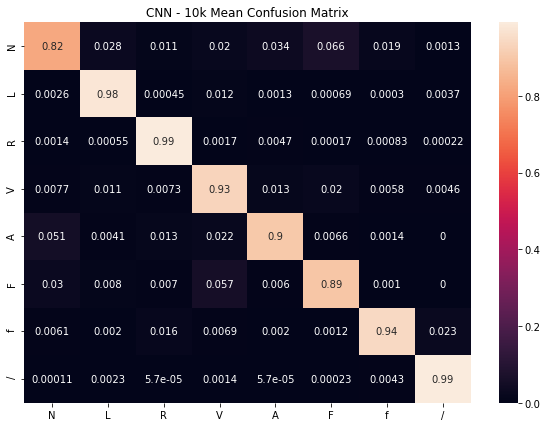

In [18]:
categories=['N','L','R','V','A','F','f','/']
cm = np.mean(cms, axis=0)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)
plt.title('CNN - 10k Mean Confusion Matrix')
# plt.savefig("lstm_mean_cm_pl.png", dpi=300)
plt.show()

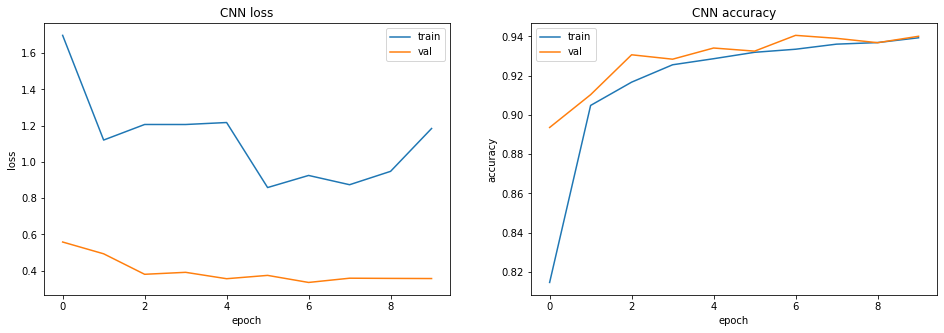

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax[0].plot(np.mean(modelosses, axis=0))
ax[0].plot(np.mean(modeleval_losses, axis=0))
ax[0].set_title('CNN loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper right')
ax[1].plot(np.mean(modelacc,axis=0))
ax[1].plot(np.mean(modeleval_acc, axis=0))
ax[1].set_title('CNN accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.show()
# fig.savefig('lstm_leaveout_patients_loss_and_accuracy.jpg')

### Extra

In [ ]:
# def gini_coefficient(x):
#     """Compute Gini coefficient of array of values"""
#     diffsum = 0
#     for i, xi in enumerate(x[:-1], 1):
#         diffsum += np.sum(np.abs(xi - x[i:]))
#     return diffsum / (len(x)**2 * np.mean(x))

In [ ]:
# input = keras.layers.Input(shape=(train_x.shape[1],train_x.shape[2]))
# x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(input)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.LeakyReLU(alpha=0.3)(x)

# #block 2

# x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.LeakyReLU(alpha=0.3)(x)
# x = keras.layers.Dropout(0.2)(x)

# #block 3
# for i in range(4):


#     shortcut = MaxPooling1D(pool_size=1)(x)

#     filters = 64 * ((i//2)+1)
#     print("Filter size = "+str(filters))
#     x = keras.layers.Conv1D(kernel_size=16, filters=filters, strides=1, use_bias=True, padding="same", kernel_initializer='VarianceScaling')(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.LeakyReLU(alpha=0.3)(x)

#     x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, padding="same", kernel_initializer='VarianceScaling')(x)

#     x = keras.layers.LeakyReLU(alpha=0.3)(x)
#     x = keras.layers.Dropout(0.2)(x)
 

#     x = tf.keras.layers.Add()([x, shortcut])


# x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.LeakyReLU(alpha=0.3)(x)
# x = keras.layers.Flatten()(x)
# out = keras.layers.Dense(9, activation='softmax')(x)
# model = tf.keras.models.Model(inputs=[input], outputs=out)